In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
import numpy as np
from scipy.io import arff
from keras.models import Sequential
from keras.layers import Dense
import matplotlib.pyplot as plt
import keras.backend as K
from keras import regularizers
import keras_tuner as kt
from keras.utils.vis_utils import plot_model
from multi_label_metrics import *
from label_info import label_counter
import seaborn as sns
tfk = tf.keras
tf.keras.backend.set_floatx("float32")
import tensorflow_probability as tfp
tfd = tfp.distributions
neg_log_likelihood = lambda x, rv_x: -rv_x.log_prob(x)
Adam = tf.keras.optimizers.Adam


In [2]:
#fix the random seed for comparison
from numpy.random import seed
seed(11)
from tensorflow.random import set_seed
set_seed(22)
data,_ = arff.loadarff('scene.arff')
df = pd.DataFrame(data) 
df=df.sample(frac=1, random_state=1) #shuffle the data
rows,cols = df.shape
input_dim = cols-6
output_dim = 6

df.head()

,Att1,Att2,Att3,Att4,Att5,Att6,Att7,Att8,Att9,Att10,...,Att291,Att292,Att293,Att294,Beach,Sunset,FallFoliage,Field,Mountain,Urban
2406,0.974915,0.866425,0.818144,0.936140,0.938583,0.935087,0.930597,1.000000,0.806074,0.717955,...,0.073742,0.005131,0.025059,0.004033,b'0',b'0',b'0',b'0',b'0',b'1'
2352,0.697012,0.760710,0.797416,0.858690,0.822442,0.720807,0.810469,0.620843,0.729764,0.783508,...,0.140970,0.115399,0.023692,0.044930,b'0',b'0',b'0',b'0',b'0',b'1'
2211,0.983764,0.991638,0.918196,0.908769,0.893647,0.843644,0.684601,1.000000,0.988726,0.885405,...,0.226596,0.162894,0.067569,0.067359,b'0',b'0',b'0',b'0',b'0',b'1'
1994,0.986745,0.986901,0.979224,0.980285,0.979826,0.951972,0.931917,0.986359,0.986667,0.986823,...,0.014017,0.012063,0.044558,0.027307,b'0',b'0',b'0',b'1',b'0',b'0'
2347,0.703788,0.739319,0.758098,0.762952,0.758033,0.741663,0.711662,0.741278,0.775669,0.815994,...,0.159946,0.192540,0.008348,0.017899,b'0',b'0',b'0',b'0',b'0',b'1'


In [3]:
split_index = int(rows * 0.8)
data_train:pd.DataFrame = df.iloc[:split_index,:]
data_test:pd.DataFrame = df.iloc[split_index:,:]
x_train = np.array(data_train.iloc[:,:-6].values,dtype ='float32')
y_train = np.array(data_train.iloc[:,-6:].values,dtype ='int')
x_test = np.array(data_test.iloc[:,:-6].values,dtype ='float32')
y_test = np.array(data_test.iloc[:,-6:].values,dtype ='int')

X = np.concatenate((x_train,x_test))
Y = np.concatenate((y_train,y_test))
label_info = label_counter(X,Y)

for l in range(len(label_info)):
    print("Number of instances with %s positive label(s): %s" %(l,label_info[l].astype("int32")))



Number of instances with 0 positive label(s): 0
Number of instances with 1 positive label(s): 2230
Number of instances with 2 positive label(s): 176
Number of instances with 3 positive label(s): 1
Number of instances with 4 positive label(s): 0
Number of instances with 5 positive label(s): 0
Number of instances with 6 positive label(s): 0


In [4]:
train_size = np.shape(x_train)[0]
train_size

1925

In [5]:
def create_model():
    kl_divergence_function = (lambda q, p, _: tfd.kl_divergence(q, p) / tf.cast(train_size, dtype='float32'))

    model = tf.keras.models.Sequential([
          Dense(
              350,activation='relu',input_dim=input_dim, dtype ='float32'),
          Dense(
              250, activation='relu', dtype ='float32'),
          Dense(
              80, activation='relu', dtype ='float32'),
          tfp.layers.DenseFlipout(
              output_dim, kernel_divergence_fn=kl_divergence_function,activation='sigmoid', dtype ='float32'),
  ])
    return model
model = create_model()

C:\Users\zhang\anaconda3\lib\site-packages\tensorflow_probability\python\layers\util.py:95: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  loc = add_variable_fn(
C:\Users\zhang\anaconda3\lib\site-packages\tensorflow_probability\python\layers\util.py:105: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  untransformed_scale = add_variable_fn(


def create_model():
    kl_divergence_function = (lambda q, p, _: tfd.kl_divergence(q, p) / tf.cast(train_size, dtype='float32'))

    model = tf.keras.models.Sequential([
          tfp.layers.DenseFlipout(
              300, kernel_divergence_fn=kl_divergence_function,activation='relu',input_dim=input_dim, dtype ='float32'),
          tfp.layers.DenseFlipout(
              200, kernel_divergence_fn=kl_divergence_function,activation='relu', dtype ='float32'),
          tfp.layers.DenseFlipout(60, kernel_divergence_fn=kl_divergence_function,
          activation='sigmoid', dtype ='float32'),
          tf.keras.layers.Dense(
          output_dim, 
          activation='sigmoid', dtype ='float32')
  ])
    return model
model = create_model()

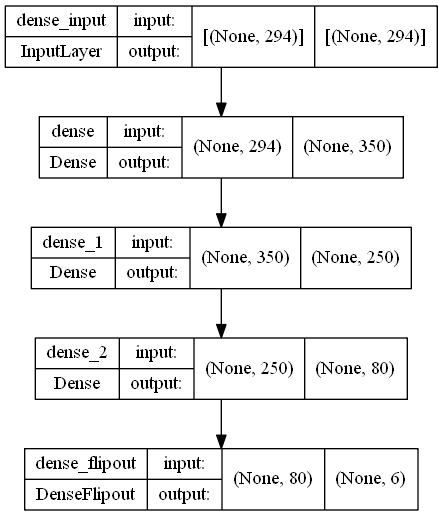

In [6]:

plot_model(model, to_file='./Model_Last_Layer_BNN_Scene.png', show_shapes=True)

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 350)               103250    
                                                                 
 dense_1 (Dense)             (None, 250)               87750     
                                                                 
 dense_2 (Dense)             (None, 80)                20080     
                                                                 
 dense_flipout (DenseFlipout  (None, 6)                966       
 )                                                               
                                                                 
Total params: 212,046
Trainable params: 212,046
Non-trainable params: 0
_________________________________________________________________


In [8]:

model.compile(loss='binary_crossentropy',optimizer = tf.keras.optimizers.Adam(learning_rate=5e-4),metrics=['binary_accuracy',hamming_loss,precision_micro,recall_micro,f1_micro])

In [9]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

history = model.fit(x_train,y_train,epochs=60,batch_size=256,validation_split=0.25,shuffle=True)

Epoch 1/60
6/6 [==============================] - 2s 84ms/step - loss: 1.2076 - binary_accuracy: 0.7990 - hamming_loss: 0.1994 - precision_micro: 0.4664 - recall_micro: 0.0581 - f1_micro: 0.0681 - val_loss: 1.1186 - val_binary_accuracy: 0.8174 - val_hamming_loss: 0.1827 - val_precision_micro: 0.0000e+00 - val_recall_micro: 0.0000e+00 - val_f1_micro: 0.0000e+00
Epoch 2/60
6/6 [==============================] - 0s 10ms/step - loss: 1.0992 - binary_accuracy: 0.8221 - hamming_loss: 0.1776 - precision_micro: 0.2222 - recall_micro: 0.0012 - f1_micro: 0.0024 - val_loss: 1.1024 - val_binary_accuracy: 0.8174 - val_hamming_loss: 0.1827 - val_precision_micro: 0.0000e+00 - val_recall_micro: 0.0000e+00 - val_f1_micro: 0.0000e+00
Epoch 3/60
6/6 [==============================] - 0s 10ms/step - loss: 1.0824 - binary_accuracy: 0.8221 - hamming_loss: 0.1784 - precision_micro: 0.0000e+00 - recall_micro: 0.0000e+00 - f1_micro: 0.0000e+00 - val_loss: 1.0643 - val_binary_accuracy: 0.8174 - val_hamming_loss

6/6 [==============================] - 0s 9ms/step - loss: 0.7372 - binary_accuracy: 0.9468 - hamming_loss: 0.0526 - precision_micro: 0.8835 - recall_micro: 0.8118 - f1_micro: 0.8457 - val_loss: 0.8074 - val_binary_accuracy: 0.9149 - val_hamming_loss: 0.0854 - val_precision_micro: 0.8021 - val_recall_micro: 0.7071 - val_f1_micro: 0.7514
Epoch 48/60
6/6 [==============================] - 0s 10ms/step - loss: 0.7330 - binary_accuracy: 0.9455 - hamming_loss: 0.0547 - precision_micro: 0.8822 - recall_micro: 0.8005 - f1_micro: 0.8391 - val_loss: 0.8082 - val_binary_accuracy: 0.9153 - val_hamming_loss: 0.0852 - val_precision_micro: 0.8142 - val_recall_micro: 0.6922 - val_f1_micro: 0.7483
Epoch 49/60
6/6 [==============================] - 0s 10ms/step - loss: 0.7302 - binary_accuracy: 0.9486 - hamming_loss: 0.0512 - precision_micro: 0.8853 - recall_micro: 0.8188 - f1_micro: 0.8503 - val_loss: 0.8077 - val_binary_accuracy: 0.9132 - val_hamming_loss: 0.0870 - val_precision_micro: 0.7937 - val_r

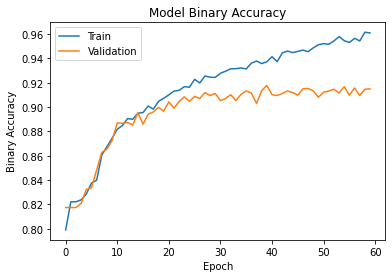

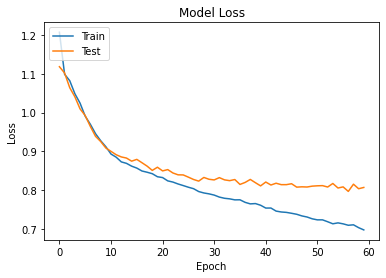

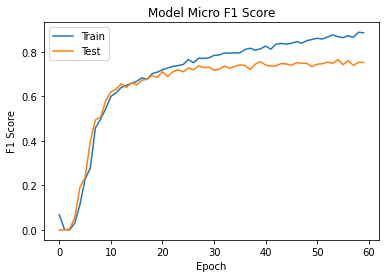

In [10]:
#Visualisation
#acc
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('Model Binary Accuracy')
plt.ylabel('Binary Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
#loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
#f1
plt.plot(history.history['f1_micro'])
plt.plot(history.history['val_f1_micro'])
plt.title('Model Micro F1 Score')
plt.ylabel('F1 Score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


In [11]:
loss, accuracy,hamming_loss,precision_micro,recall_micro,f1_micro = model.evaluate(x_test, y_test)
print('Test:')
print('Loss: %s\nBinary-Accuracy(the same as Micro-Accuracy): %s \nHamming_Loss: %s \nMicro-Precision: %s \nMicro-Recall: %s \nMicro-F1 Score: %s' % (loss, accuracy,hamming_loss,precision_micro,recall_micro,f1_micro))

16/16 [==============================] - 0s 2ms/step - loss: 0.8283 - binary_accuracy: 0.9111 - hamming_loss: 0.0934 - precision_micro: 0.7619 - recall_micro: 0.6966 - f1_micro: 0.7269
Test:
Loss: 0.8283146023750305
Binary-Accuracy(the same as Micro-Accuracy): 0.9111341238021851 
Hamming_Loss: 0.0934244841337204 
Micro-Precision: 0.7619481086730957 
Micro-Recall: 0.6965916156768799 
Micro-F1 Score: 0.7269493341445923


In [12]:
y_pred = model.predict(x_test)

In [13]:
instance_1 = np.reshape(x_test[45],(1,294))
instance_2 = np.reshape(x_test[50],(1,294))

In [14]:
num_ensemble = 500
y_pred_all_idx1 = []
y_pred_all_idx2 = []
y_pred_all = []
for e in range(num_ensemble):
    
    y_pred_idx1 = model.predict(instance_1)
    y_pred_all_idx1.append(y_pred_idx1)
    y_pred_idx2 = model.predict(instance_2)
    y_pred_all_idx2.append(y_pred_idx2)
    y_pred = model.predict(x_test)
    y_pred_all.append(y_pred)

In [15]:
y_pred_m_1 = np.mean(y_pred_all_idx1, axis=0)
y_pred_s_1 = np.std(y_pred_all_idx1, axis=0)
y_pred_m_2 = np.mean(y_pred_all_idx2, axis=0)
y_pred_s_2 = np.std(y_pred_all_idx2, axis=0)
y_pred_m = np.mean(y_pred_all,axis=0)
y_pred_s = np.std(y_pred_all,axis=0)

In [16]:
labels=np.linspace(1,6,6)


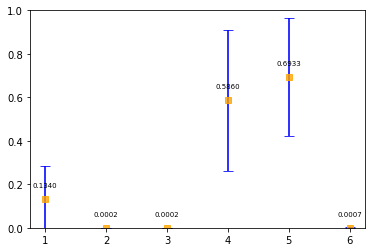

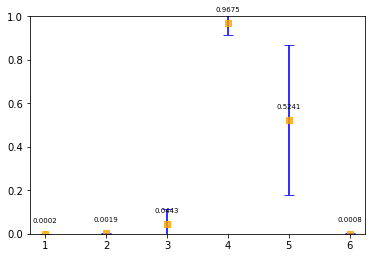

In [17]:
plt.errorbar(labels,y_pred_m_1[0],yerr=1.96*y_pred_s_1[0],fmt='s',ecolor='blue',color='orange',elinewidth=2,capsize=5,alpha=0.8)
plt.ylim((0, 1))
for a,b in zip(labels,y_pred_m_1[0]):
    plt.text(a, b+0.05, '%.4f' % b, ha='center', va= 'bottom',fontsize=7)
plt.savefig("./Last_Layer_BNN_Prediction_Exemple_1_Scene.jpg" ,bbox_inches="tight")    
plt.show()
plt.errorbar(labels,y_pred_m_2[0],yerr=1.96*y_pred_s_2[0],fmt='s',ecolor='blue',color='orange',elinewidth=2,capsize=5,alpha=0.8)
plt.ylim((0, 1))
for a,b in zip(labels,y_pred_m_2[0]):
    plt.text(a, b+0.05, '%.4f' % b, ha='center', va= 'bottom',fontsize=7)
plt.savefig("./Last_Layer_BNN_Prediction_Exemple_2_Scene.jpg" ,bbox_inches="tight")  
plt.show()

In [18]:
np.sum(y_test,axis=1)

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 2, 1, 1,
       1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 2, 1, 2, 2,

In [19]:
print(y_test[45])
y_pred[45]


[0 0 0 1 1 0]


array([8.8220477e-02, 3.9839433e-05, 2.8097630e-04, 5.0371915e-01,
       7.3075497e-01, 1.0722578e-03], dtype=float32)

In [20]:
y_pred_m #ensemble's mean predictive value used for ECE and Reliability Diagramm

array([[6.64635420e-01, 9.03169252e-03, 3.69019538e-01, 1.40840318e-02,
        6.90614153e-03, 2.22189322e-01],
       [5.48363507e-01, 9.77832606e-05, 1.50893803e-03, 1.36114061e-01,
        1.05767466e-01, 5.67521490e-02],
       [4.41724688e-01, 1.22764623e-02, 3.41274559e-01, 5.17991036e-02,
        6.25488441e-03, 7.04241395e-02],
       ...,
       [2.68495250e-02, 6.04833215e-02, 2.09995378e-02, 7.33647048e-02,
        2.47953143e-02, 5.84020793e-01],
       [1.38359674e-05, 9.99296486e-01, 3.34921526e-04, 7.56184018e-05,
        7.54608918e-05, 7.68678365e-05],
       [3.41226859e-03, 6.80473214e-03, 7.02837259e-02, 1.43781871e-01,
        9.17118967e-01, 5.24425432e-02]], dtype=float32)

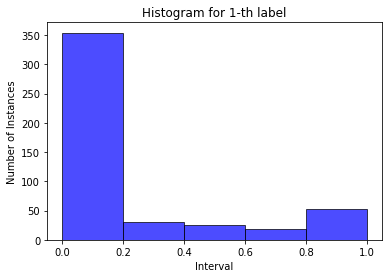

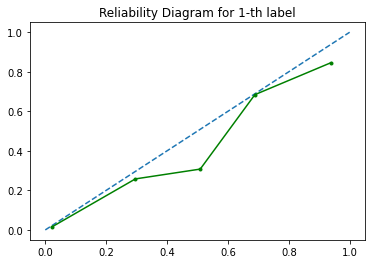

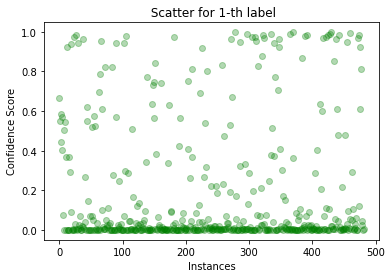

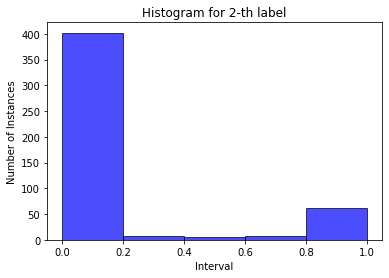

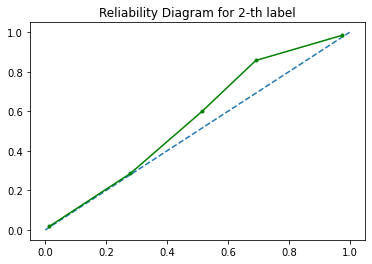

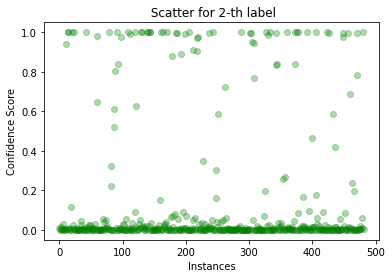

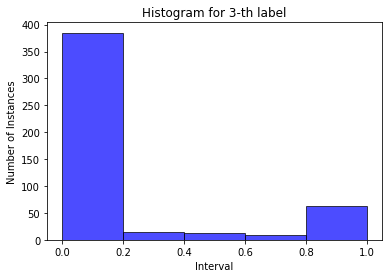

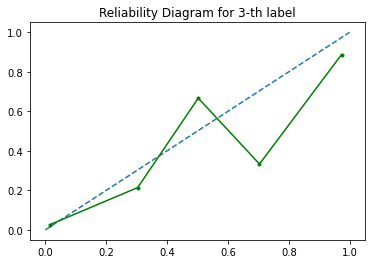

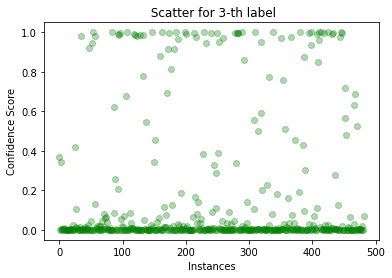

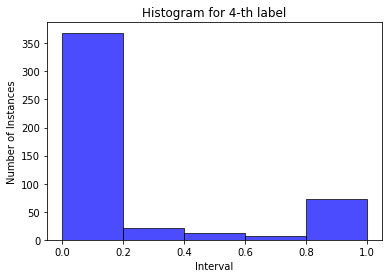

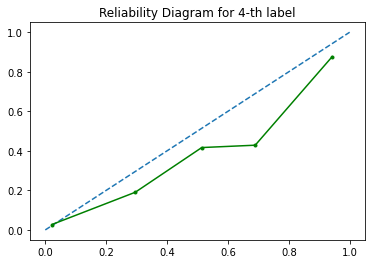

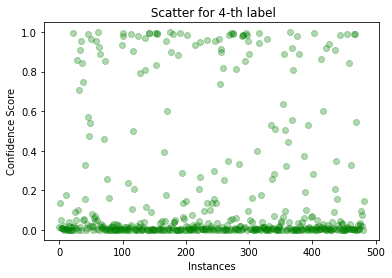

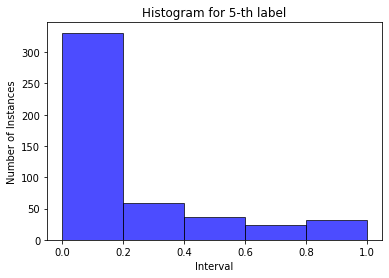

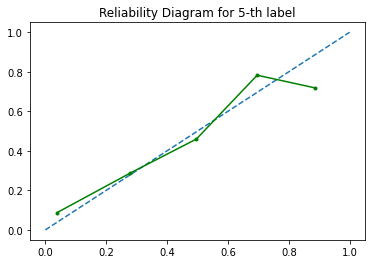

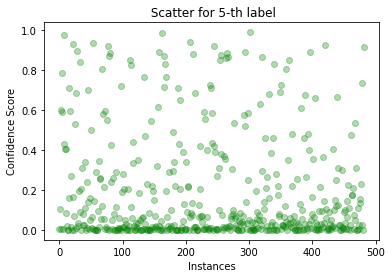

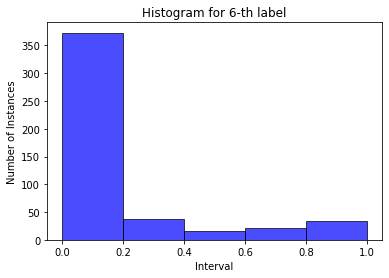

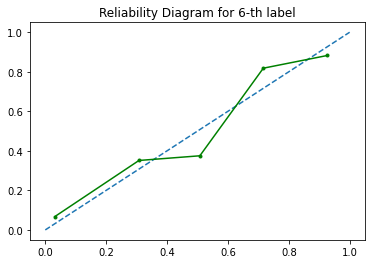

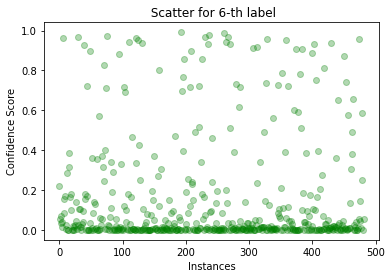

Expected Calibration Error for each label = [0.028229559001010117, 0.00863751123425379, 0.03395403383465199, 0.02512897984954173, 0.05255369835742121, 0.04346633141242799]
Average Expected Calibration Error for all labels = 0.0319950189482178


In [21]:
from sklearn.calibration import calibration_curve
from BM import bm_counter
#Histograms of predictive value and reliability diagrams to show non-calibration 
ECE=[]
ECE_cal = []
bins =5
for i in range(np.shape(y_test)[1]):
    #histogram
    plt.hist(y_pred_m[:,i],bins = bins,range=(0,1),facecolor="blue", edgecolor="black", alpha=0.7)
    plt.title('Histogram for %s-th label' %(i+1))
    plt.ylabel('Number of Instances')
    plt.xlabel('Interval')
    plt.savefig("./Last_Layer_BNN_Scene_Hist_%s.jpg" %(i+1))
    plt.show()
    
    #reliability diagram
    prob_true, prob_pred = calibration_curve(y_test[:,i], y_pred_m[:,i], n_bins=bins) #acc for each bin, avg pred for each bin 
    Bm = bm_counter(y_pred_m[:,i],bins)
    Bm = Bm[Bm != 0]
    temp_ece=np.sum(abs(prob_pred - prob_true)*Bm)/np.shape(y_pred_m)[0]
    ECE.append(temp_ece)
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.plot(prob_pred, prob_true, marker='.',label = 'uncalibrated',color = "green")
    plt.title('Reliability Diagram for %s-th label' %(i+1))
    plt.savefig("./Last_Layer_BNN_Scene_RD_%s.jpg" %(i+1),bbox_inches="tight")
    plt.show()
    
    plt.scatter(range(np.shape(y_pred_m)[0]),y_pred_m[:,i],color = "green",label = ' uncalibrated',alpha= 0.3)
    plt.title(' Scatter for %s-th label' %(i+1))
    plt.ylabel('Confidence Score')
    plt.xlabel('Instances')
    plt.savefig("./Scene_Scatter_Last_Layer_%s.jpg" %(i+1),bbox_inches="tight")
    plt.show()
print('Expected Calibration Error for each label = %s' %ECE)
avg_ECE = np.mean(ECE)
print('Average Expected Calibration Error for all labels = %s' %avg_ECE)

In [22]:
predictions = (y_pred_m > 0.5).astype("int32")
recall_macro(y_test,predictions)

(array([0.80769231, 0.87179487, 0.78481013, 0.8372093 , 0.47115385,
        0.57608696]),
 0.7247912351784375)

In [23]:
precision_macro(y_test,predictions)


(array([0.71590909, 0.95774648, 0.80519481, 0.80898876, 0.68055556,
        0.828125  ]),
 0.7994199490962725)

In [24]:
f1_macro(y_test,predictions)

(array([0.75903614, 0.91275168, 0.79487179, 0.82285714, 0.55681818,
        0.67948718]),
 0.7543036869108269)

In [25]:
accuracy_each_label(y_test,predictions)

array([0.91701245, 0.97302905, 0.93360996, 0.93568465, 0.83817427,
       0.89626556])

In [26]:
np.mean(accuracy_each_label(y_test,predictions))

0.9156293222683264

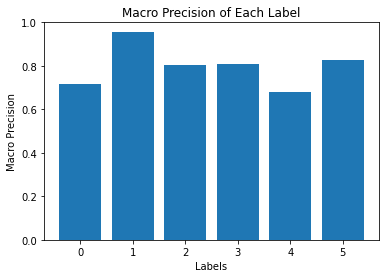

In [27]:
plt.bar(range(6),precision_macro(y_test,predictions)[0])
plt.ylim((0, 1))
plt.title('Macro Precision of Each Label')
plt.ylabel('Macro Precision')
plt.xlabel('Labels')
plt.savefig("./BNN_scene_macro_precision.jpg" )

In [28]:
ECE_BL = [0.060630153622409005, 0.03153341677251923, 0.060561192467757825, 0.048878226472368905, 0.11836547996034369, 0.09480137570027052]

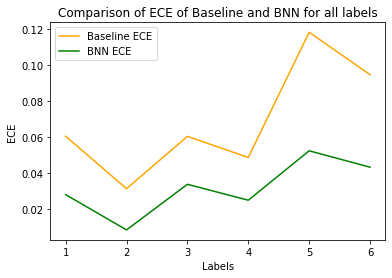

In [29]:
#calibrated model for test data evaluation Macro
plt.plot([1,2,3,4,5,6],ECE_BL, label='Baseline ECE',color = "orange")
plt.plot([1,2,3,4,5,6],ECE,color = "green",label = 'BNN ECE')
plt.title('Comparison of ECE of Baseline and BNN for all labels')
plt.ylabel('ECE')
plt.xlabel('Labels')
plt.legend()
plt.savefig("./scene_ece_comparison_BNN.jpg" )
plt.show()
